In [1]:
from google.colab import drive 
drive.mount('./drive')

Mounted at ./drive


In [2]:
!unzip -q ./drive/MyDrive/Colab\ Notebooks/ML-2/Kaggle\ 1/data/test.zip
!unzip -q ./drive/MyDrive/Colab\ Notebooks/ML-2/Kaggle\ 1/data/train.zip
!cp ./drive/MyDrive/Colab\ Notebooks/ML-2/Kaggle\ 1/data/test.csv test.csv
!cp ./drive/MyDrive/Colab\ Notebooks/ML-2/Kaggle\ 1/data/train.csv train.csv

In [3]:
!pip install -q lightning-bolts

     |████████████████████████████████| 316 kB 9.7 MB/s 
     |████████████████████████████████| 582 kB 72.0 MB/s 
     |████████████████████████████████| 398 kB 71.2 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 136 kB 74.6 MB/s 
     |████████████████████████████████| 1.1 MB 53.6 MB/s 
     |████████████████████████████████| 271 kB 74.4 MB/s 
     |████████████████████████████████| 144 kB 75.2 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


# [Competition 1, Sem 2, Yandex SHAD, Spring 2022](https://www.kaggle.com/t/4cfb0dde745848b8b2a60aa0ee1bdcbe)
## Baseline

In [ ]:
import csv
import time
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as tt

from PIL import Image
from pathlib import Path
from random import randint
from torch.optim import Adam
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models.resnet import resnet34, resnext101_32x8d

import os
from sklearn.metrics.pairwise import cosine_distances
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'

IMAGES_PATH = Path('train')

### Данные

In [ ]:
meta = pd.read_csv('train.csv')
meta.head(3)

,image_id,person_id
0,0,0
1,1,0
2,2,0


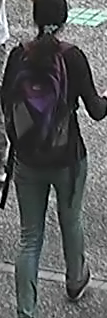

In [ ]:
row = meta.iloc[randint(0, len(meta))]
Image.open(IMAGES_PATH / (str(row.image_id )+ '.png'))

Реализуйте `ReIdDataset`, который можно будет использоваться в качестве аргумента в `torch.utils.data.DataLoader`. 

Класс может загружать картинки во время вызова `__getitem__`, 

или прочитать их все сразу в оперативную память в `__init__`. 

Для загрузки картинок рекомендуется использовать `PIL.Image` из пакета `pillow`.

[Пример](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) реализации кастомных датасетов.

In [ ]:
class ReIdDataset:
    def __init__(self, data_df, images_path, transforms=None, augmentation=False):
        self.meta = data_df
        self.images_path = images_path
        self.transforms = transforms
        self.augmentation = augmentation

    def __len__(self):
        return len(self.meta)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_id = self.meta.iloc[idx, 0]
        try:
            person_id = self.meta.iloc[idx, 1]
        except IndexError:
            person_id = -1
        img_name = os.path.join(self.images_path,
                                str(image_id) + '.png')
        image = Image.open(img_name)

        if self.augmentation:
            image = tt.RandAugment(num_ops=3)(image)

        if self.transforms:
            image = self.transforms(image)

        return {
            'image_id': image_id,
            'image': image,
            'person_id': person_id,
        }

Реализуйте `DataLoader`, обратив внимание на то, что картинки идут в разных разрешениях, 

поэтому в батче их нужно будет привести к одному размеру, что можно сделать при помощи `torchvision.transforms.Resize`.

---

Разделим train на обучение и валидацию (person_id не пересекаются):

In [ ]:
np.random.seed(42)
unique_persons = meta['person_id'].unique()
val_persons = np.random.choice(unique_persons, 
                                size=int(0.1 * len(unique_persons)), 
                                replace=False)
train_df = meta.loc[~meta['person_id'].isin(val_persons)]
val_df = meta.loc[meta['person_id'].isin(val_persons)]

print(train_df.shape[0], '|', val_df.shape[0])

11851 | 1301


Создадим DataLoader'ы для обучения и валидации, а для обучающего датасета сделаем аугментацию изображений:

In [ ]:
transforms = tt.Compose([
    tt.Resize((224, 112)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# для обучения и валидации
dataset_train = ReIdDataset(train_df, IMAGES_PATH, transforms=transforms)
dataset_val = ReIdDataset(val_df.copy(), IMAGES_PATH, transforms=transforms)
dataset_val.meta.drop('person_id', axis=1, inplace=True)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=1)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=1)

# для финального обучения на всех данных
dataset = ReIdDataset(meta, IMAGES_PATH, transforms=transforms)
dataset_augmented = [ReIdDataset(meta, IMAGES_PATH, transforms=transforms, augmentation=True) 
                     for _ in range(1)]
dataset = ConcatDataset([dataset] + dataset_augmented)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

print('Train dataset (original):')
print(len(dataset_train))
print('Validation dataset:')
print(len(dataset_val))
print('Final dataset (whole train + augmentation):')
print(len(dataset))

Train dataset (original):
11851
Validation dataset:
1301
Final dataset (whole train + augmentation):
26304


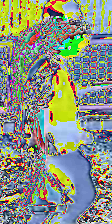

In [ ]:
one_item = next(iter(val_loader))
tt.ToPILImage()(one_item['image'][0])

### Обучение

#### Обычный классификатор

In [ ]:
def train_epoch(model, criterion, optimizer, loader, device):
    model.train()
    model = model.to(device)
    start = time.time()

    for i, batch in enumerate(loader):
        images = batch['image'].to(device)
        labels = batch['person_id'].to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions['classes'], labels)
        loss.backward()
        optimizer.step()
        accuracy = (predictions['classes'].max(-1)[-1] == labels).to('cpu').detach().numpy().mean()
        print(f'batch {i+1}/{len(loader)} | loss={loss.item():.3f} | acc={accuracy:.2f}', end='\r' if i+1!=len(loader) else '\n')

    end = time.time()
    print(f'elapsed {end - start:0.0f} seconds')

#### Эмбеддер с триплет лоссом

In [ ]:
def get_random_batch(train_df, p, k, images_path, transforms):
    """
    Sample (p*k)-sized batch of random p persons and k photos per each
    """
    p = np.min([p, train_df['person_id'].nunique()])
    k = np.min([k, train_df['person_id'].value_counts().min()])
    persons = train_df['person_id'].unique()
    persons_sample = np.random.choice(persons, size=p, replace=False)
    images_sample = np.array([], int)

    for person in persons_sample:
        images = train_df.loc[train_df['person_id'] == person]['image_id']
        sample = np.random.choice(images, size=k, replace=False)
        images_sample = np.append(images_sample, sample)
        
    train_sample = train_df.loc[train_df['image_id'].isin(images_sample)].sort_values(by='image_id')
    assert train_sample.shape[0] == p*k

    dataset = ReIdDataset(train_sample, images_path, transforms=transforms)
    loader = DataLoader(dataset, batch_size=int(p*k), shuffle=False, num_workers=1)
    return next(iter(loader))

In [ ]:
def get_hard_triplets(model, images, labels):
    """
    Return triplets - batch of [anchor, positive, negative]
    """
    embeddings = model(images).detach().cpu().numpy()
    distances = cosine_distances(embeddings)
    persons = np.unique(labels)
    np.fill_diagonal(distances, np.nan) # ignore distance to itself
    anchors, positives, negatives = [], [], []

    for person in persons:
        image_indices = np.where(labels == person)[0]
        anchor_index = image_indices[0]   # first photo of person as anchor
        same_person_mask = (labels == person)

        # Masked values of True exclude the corresponding element from any computation
        distances_pos = np.ma.array(distances[anchor_index], mask=~same_person_mask)
        distances_neg = np.ma.array(distances[anchor_index], mask=same_person_mask)

        # the farthest embedding of same person
        positive_index = np.nanargmax(distances_pos)

        # the nearest embedding of another person
        negative_index = np.nanargmin(distances_neg)

        anchors.append(images[anchor_index])
        positives.append(images[positive_index])
        negatives.append(images[negative_index])

    triplets = torch.vstack([torch.stack(anchors), 
                             torch.stack(positives), 
                             torch.stack(negatives)])
    return triplets

In [ ]:
def train_epoch_triplet(model_embedder, triplet_loss, optimizer, 
                        device=DEVICE, train_df=train_df, 
                        images_path=IMAGES_PATH, transforms=transforms, 
                        p=32, k=4, iterations=10):
    model_embedder.train()
    model_embedder = model_embedder.to(device)
    start = time.time()
    losses = []

    for i in range(iterations):
        batch = get_random_batch(train_df, p, k, images_path, transforms)
        images = batch['image'].to(device)
        labels = batch['person_id']
        optimizer.zero_grad()
        triplets = get_hard_triplets(model_embedder, images, labels)
        optimizer.zero_grad() 
        output = model(triplets)
        anchor, positive, negative = torch.split(output, p)
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(f'Iteration: {i}, triplet_loss: {loss.item():.3f}')

    print(f'avg_triplet_loss = {np.mean(losses):.3f}')
    end = time.time()
    print(f'elapsed {end - start:0.0f} seconds')

В качестве backbone для baseline решения используется архитектура [resnet34](https://github.com/pytorch/vision/blob/a4736ea6e8ff25a1265ca5adf9e6e244d78500e8/torchvision/models/resnet.py#L244). 

Обратите внимание на флаг `pretrained`: если он включен, то загрузятся веса модели, обученной на датасете [ImageNet](http://www.image-net.org/). 

Это позволит нам сразу использовать "хорошие" признаки, поверх которых мы обучим модель re-id.

Реализуйте метод `get_embeddings` -- должен возвращать признаки, которые идут на вход слоя `resnet34.fc` (смотри `ResNet._forward_impl` по ссылке выше). 

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.backbone = resnet34(pretrained=True, progress=False)
        # self.backbone = resnext101_32x8d(pretrained=True, progress=False)
        self.backbone.fc = torch.nn.Identity()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.classifier = torch.nn.Linear(512, n_classes, bias=False)

    def get_embeddings(self, x):
        return self.backbone(x)

    def forward(self, x):
        embeddings = self.get_embeddings(x)
        droppedout = self.dropout(embeddings)
        classes = self.classifier(droppedout)
        return {
            'embeddings': embeddings,
            'classes': classes,
        }

class Model_Embedder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet34(pretrained=True, progress=False)
        self.backbone.fc = torch.nn.Identity()

        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# N = meta['person_id'].nunique()
# model = Model(n_classes=N).to(DEVICE)

model = Model_Embedder().to(DEVICE)

### Обучение модели-эмбеддера с Triplet Loss

In [ ]:
optimizer = Adam(model.parameters(), lr=0.0015, amsgrad=True)
criterion = torch.nn.TripletMarginLoss(margin=1.0)

In [ ]:
N_EPOCHS = 30
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=N_EPOCHS//5, max_epochs=N_EPOCHS)

for i in range(N_EPOCHS):
    print(f'EPOCH {i+1}')
    train_epoch_triplet(model, criterion, optimizer, train_df=train_df, p=32, k=4, iterations=40)
    scheduler.step()

EPOCH 1
avg_triplet_loss = 4.718
elapsed 49 seconds
EPOCH 2
avg_triplet_loss = 2.784
elapsed 45 seconds
EPOCH 3
avg_triplet_loss = 2.136
elapsed 45 seconds
EPOCH 4
avg_triplet_loss = 1.695
elapsed 43 seconds
EPOCH 5
avg_triplet_loss = 1.299
elapsed 49 seconds
EPOCH 6
avg_triplet_loss = 1.120
elapsed 47 seconds
EPOCH 7
avg_triplet_loss = 0.961
elapsed 42 seconds
EPOCH 8
avg_triplet_loss = 0.827
elapsed 44 seconds
EPOCH 9
avg_triplet_loss = 0.756
elapsed 45 seconds
EPOCH 10
avg_triplet_loss = 0.742
elapsed 44 seconds
EPOCH 11
avg_triplet_loss = 0.624
elapsed 48 seconds
EPOCH 12
avg_triplet_loss = 0.592
elapsed 46 seconds
EPOCH 13
avg_triplet_loss = 0.537
elapsed 50 seconds
EPOCH 14
avg_triplet_loss = 0.499
elapsed 44 seconds
EPOCH 15
avg_triplet_loss = 0.452
elapsed 43 seconds
EPOCH 16
avg_triplet_loss = 0.392
elapsed 42 seconds
EPOCH 17
avg_triplet_loss = 0.326
elapsed 43 seconds
EPOCH 18
avg_triplet_loss = 0.293
elapsed 42 seconds
EPOCH 19
avg_triplet_loss = 0.267
elapsed 42 seconds
EP

In [ ]:
# Сохранить модель
torch.save(model.state_dict(), './model_new-2.pt')

In [ ]:
!cp model_new-2.pt drive/MyDrive/model_new-2.pt

### Fine tuning (бейзлайн с классификатором)

Так как наш датасет очень мал (~10_000 картинок), то тюнинг всех весов модели может привести к переобучению. Более того, если случайно проинициализировать веса последнего полносвязного слоя, то получится градиент с большой нормой, который "выбросит" остальные веса модели из области с "хорошими" признаками. 

Поэтому рекомендуется сначала обучить просто классификатор поверх "замороженного" backbone'а. Ключевое слово -- `requires_grad`

In [ ]:
# заморозьте все веса модели
for param in model.parameters():
    param.requires_grad = False

# разморозьте веса классификатора людей
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
optimizer = Adam(model.parameters(), lr=0.0015, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for i in range(2):
    print(f'EPOCH {i+1}')
    train_epoch(model, criterion, optimizer, train_loader, device=DEVICE)

EPOCH 1
batch 186/186 | loss=6.047 | acc=0.00
elapsed 55 seconds
EPOCH 2
batch 186/186 | loss=4.614 | acc=0.27
elapsed 55 seconds


Обучите остальные веса, не трогая ранние слои, поэтому попробуем обучить только `model.backbone.layer4` (имя слоя можно подсмотреть в коде модели).

In [ ]:
# разморозьте model.backbone.layer4
for param in model.backbone.layer4.parameters():
    param.requires_grad = True

Обучите вместе классификатор и `model.backbone.layer4`

In [ ]:
for i in range(5):
    print(f'EPOCH {i+1}')
    train_epoch(model, criterion, optimizer, train_loader, device=DEVICE)

EPOCH 1
batch 186/186 | loss=3.009 | acc=0.36
elapsed 48 seconds
EPOCH 2
batch 186/186 | loss=1.275 | acc=0.64
elapsed 49 seconds
EPOCH 3
batch 186/186 | loss=0.587 | acc=0.91
elapsed 49 seconds
EPOCH 4
batch 186/186 | loss=0.567 | acc=0.91
elapsed 49 seconds
EPOCH 5
batch 186/186 | loss=0.097 | acc=1.00
elapsed 49 seconds


### Валидация

Так как множества людей в обучающих и тестовых данных не пересекаются, то слой классификатора нам бесполезен. Однако, в силу того, как мы обучали нашу модель, мы можем использовать наши эмбединги, чтобы сравнивать между собой людей. Сравнивать их можно по косиносному расстоянию, так как учили cross-entropy поверх softmax (подумайте, почему).

In [ ]:
def get_features(model, loader, device):
    model.eval()
    features, images_ids = [], []
    for batch in loader:
        # batch_features = model(batch['image'].to(device))['embeddings']
        batch_features = model(batch['image'].to(device))
        features.extend(batch_features.to('cpu').data.numpy())
        images_ids.extend(batch['image_id'])
    features = np.array(features)
    images_ids = np.array(images_ids)
    return features, images_ids

Реализуйте функцию подсчета *расстояния* между всеми парами эмбеддингов.

In [ ]:
def cos_dist(features):
    return cosine_distances(features)

Добавим функции для расчета mAP (Mean Average Precision):

In [ ]:
def precision_at_k(relevance: np.array, k: int):
    return np.mean(relevance[:k] == 1)

def average_precision(relevance: np.array, 
                      ground_true_prositives: int):
    ap = np.sum([precision_at_k(relevance, k+1) * relevance[k] 
                  for k in range(len(relevance))])
    ap /= ground_true_prositives
    return ap

def AP_per_query(queries: np.array, 
                  galleries: np.array, 
                  image_to_person_id_mapping: dict, 
                  gtp_mapping: dict):
    """
    :param queries - N image_id strings of queries
    :param galleries - N sets of Top-20 relevant images ids strings
    :param image_to_person_id_mapping - true answers
    :param gtp_mapping - persons_id as a key, count of persons total in as a value
    :return Average precision per each query
    """
    img_to_person = np.vectorize(image_to_person_id_mapping.get)
    queries_persons = img_to_person(queries)
    galleries_persons = np.array([img_to_person(gallery) for gallery in galleries])
    gtp_per_query = np.vectorize(gtp_mapping.get)(queries_persons)
    relevances = np.array([(gallery == query).astype(int) for query, gallery in zip(queries_persons, galleries_persons)])
    # "grp-1" т.к. удалили того же человека с топ-1 позиции
    avg_precisions = [average_precision(r, gtp-1) for r, gtp in zip(relevances, gtp_per_query)]
    return avg_precisions

Оценим качество модели на валидационной выборке:

In [ ]:
features_val, images_ids_val = get_features(model, val_loader, device=DEVICE)
similarity_val = cos_dist(features_val)
order_val = np.argsort(similarity_val)[:, :21]
submit_val = np.take(images_ids_val, order_val)

In [ ]:
queries = val_df['image_id'].values
galleries = np.delete(submit_val, 0, axis=1) # убрали топ-1 из топ-21 (этот же человек)
image_to_person_id_mapping = dict(zip(val_df['image_id'], val_df['person_id']))
gtp_mapping = val_df['person_id'].value_counts().to_dict()

Score модели (mAP) на отложенной выборке: 0.6740
Score модели (mAP) в соревновании: ~0.6-0.7


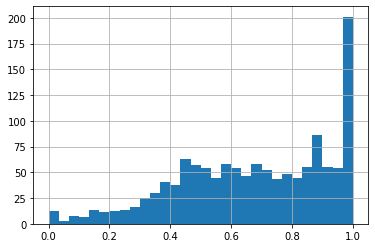

In [ ]:
aps = AP_per_query(queries, 
                   galleries, 
                   image_to_person_id_mapping, 
                   gtp_mapping)
print(f'Score модели (mAP) на отложенной выборке: {np.mean(aps):.4f}')
print(f'Score модели (mAP) в соревновании: ~0.6-0.7')
pd.Series(aps).hist(bins=30)

### Добучение модели c размороженными слоями на всей выборке для итогового предсказания

In [ ]:
# Загрузить модель
model.load_state_dict(torch.load('drive/MyDrive/model_new-2.pt'))

<All keys matched successfully>

In [ ]:
for param in model.backbone.parameters():
    param.requires_grad = True

In [ ]:
optimizer = Adam(model.parameters(), lr=0.00005, amsgrad=True)
criterion = torch.nn.TripletMarginLoss(margin=0.1)
N_EPOCHS = 10

for i in range(N_EPOCHS):
    print(f'EPOCH {i+1}')
    train_epoch_triplet(model, criterion, optimizer, train_df=meta, p=32, k=4, iterations=40)

EPOCH 1
avg_triplet_loss = 0.018
elapsed 62 seconds
EPOCH 2
avg_triplet_loss = 0.024
elapsed 62 seconds
EPOCH 3
avg_triplet_loss = 0.018
elapsed 62 seconds
EPOCH 4
avg_triplet_loss = 0.016
elapsed 61 seconds
EPOCH 5
avg_triplet_loss = 0.012
elapsed 61 seconds
EPOCH 6
avg_triplet_loss = 0.016
elapsed 62 seconds
EPOCH 7
avg_triplet_loss = 0.014
elapsed 62 seconds
EPOCH 8
avg_triplet_loss = 0.013
elapsed 62 seconds
EPOCH 9
avg_triplet_loss = 0.015
elapsed 62 seconds
EPOCH 10
avg_triplet_loss = 0.011
elapsed 62 seconds


In [ ]:
# Сохранить модель
torch.save(model.state_dict(), './model_new-21.pt')

In [ ]:
!cp model_new-21.pt drive/MyDrive/model_new-21.pt

### Сгенерируем сабмит

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head(3)

,image_id
0,e212368e-9e0b-495c-8d7f-ddf363c407e2
1,d31e0219-4752-4001-8d04-70d4c039b5ed
2,6081f702-5924-4a23-b32f-cc66a2df6de1


In [ ]:
test_dataset = ReIdDataset(test_df, Path('test'), transforms=transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
features, images_ids = get_features(model, test_loader, device=DEVICE)
features.shape

(945, 512)

In [ ]:
# Так как считается MAP@20, то нам нужно для каждого человека взять 20 его ближайших соседей.
# Самый ближайший сосед - это сам человек, но в сабмит его отправлять не нужно, поэтому берем первые 21 соседей.
similarity = cos_dist(features)
order = np.argsort(similarity)[:, :21]
submit = np.take(images_ids, order)
submit.shape

(945, 21)

In [ ]:
with open('triplet_3', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['query', 'retrieval'])
    writer.writeheader()
    for row in submit:
        writer.writerow({
            'query': row[0],
            'retrieval': ' '.join(row[1:])
        })

In [ ]:
!cp triplet_3 ./drive/MyDrive/triplet_3

### Попробуйте ещё

0. ✅ [Triplet Loss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)
1. ✅ Локальную валидацию
2. ✅ [Аугментации](https://pytorch.org/docs/stable/torchvision/transforms.html): `torchvision.transforms.{ColorJitter,Random*}`
3. ✅ [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) перед слоем классификатора
4. ✅ Обучить больше эпох -- особенно актуально, если используются регуляризации и аугментации
5. ❌ [Re-ranking](https://arxiv.org/abs/1701.08398)
6. ❌ [Am-softmax](https://arxiv.org/pdf/1801.05599.pdf). Обратите внимание на активацию relu перед слоем эмбеддингов
7. ✅ Попробуйте разные архитектуры для fine tuning'а: [torchvision.models](https://pytorch.org/vision/0.8/models.html), [EfficientNet](https://github.com/lukemelas/EfficientNet-PyTorch).
8. ✅ Последние эпохи учить модель с меньшим шагом обучения: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate (попробуйте [MultiStepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiStepLR) или [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR)).
9. ✅ Почитать статьи с трюками для обучения [нейронок](https://arxiv.org/abs/1812.01187)/[reid](https://openaccess.thecvf.com/content_CVPRW_2019/papers/TRMTMCT/Luo_Bag_of_Tricks_and_a_Strong_Baseline_for_Deep_Person_CVPRW_2019_paper.pdf).